In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, metrics, callbacks
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

import tensorflow.keras
from keras.utils.layer_utils import count_params

from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os, itertools
import matplotlib.pyplot as plt

pixel = 224
PATH = os.path.join(f'./drive/MyDrive/Skin Cancer MNIST: HAM10000/data/input_feature_extractor')
n_classes = 7

In [ ]:
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall

def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision

def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Data load for training feature extractor

In [ ]:
X_train_img = np.load(os.path.join(PATH, f"X_train_img_seed0.npy"))

y_train = np.load(os.path.join(PATH, "y_train_seed0.npy"))

X_train_meta = pd.read_csv(os.path.join(PATH, "X_train_meta_seed0.csv"))

In [ ]:
X_test_img = np.load(os.path.join(PATH, f"X_test_img_seed0.npy"))

y_test = np.load(os.path.join(PATH, "y_test_seed0.npy"))

X_test_meta = pd.read_csv(os.path.join(PATH, "X_test_meta_seed0.csv"))

### Make feature extractor

In [ ]:
pre_trained_model = VGG16(weights='imagenet', include_top=False, input_shape=(pixel, pixel, 3))

for layer in pre_trained_model.layers:
  layer.trainable = False

x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(2048)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(1024)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(512)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(n_classes, activation='softmax')(x)
model = models.Model(pre_trained_model.input, x)

optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer, 
    metrics=['accuracy', recall, precision, f1score]
)

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
print(f"Total params: {model.count_params():,}")
print(f"Trainalbe params: {count_params(model.trainable_weights):,}")
print(f"Non-trainable params: {count_params(model.non_trainable_weights):,}")

Total params: 68,809,415
Trainalbe params: 54,087,175
Non-trainable params: 14,722,240


### Train feature extractor

In [ ]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    verbose=1, 
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    verbost=1
)

In [ ]:
BATCH_SIZE = 128
EPOCHS = 60

history = model.fit(
    X_train_img, y_train,
    validation_data = (X_test_img, y_test),
    steps_per_epoch=(X_train_img.shape[0] // BATCH_SIZE),
    validation_steps=(X_test_img.shape[0] // BATCH_SIZE),
    callbacks=[reduce_lr, early_stop],
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/60
62/62 [==============================] - 98s 2s/step - loss: 1.8489 - accuracy: 0.3612 - recall: 0.1261 - precision: 0.4683 - f1score: 0.1975 - val_loss: 1.8397 - val_accuracy: 0.3789 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 2/60
62/62 [==============================] - 75s 1s/step - loss: 1.3897 - accuracy: 0.5628 - recall: 0.2828 - precision: 0.7623 - f1score: 0.4107 - val_loss: 1.3770 - val_accuracy: 0.6490 - val_recall: 0.0080 - val_precision: 0.6333 - val_f1score: 0.0158
Epoch 3/60
62/62 [==============================] - 76s 1s/step - loss: 1.1760 - accuracy: 0.6428 - recall: 0.3927 - precision: 0.8209 - f1score: 0.5302 - val_loss: 1.1647 - val_accuracy: 0.6995 - val_recall: 0.3470 - val_precision: 0.9296 - val_f1score: 0.5040
Epoch 4/60
62/62 [==============================] - 75s 1s/step - loss: 1.0224 - accuracy: 0.7004 - recall: 0.4792 - precision: 0.8586 - f1score: 0.6143 - val_loss: 1.0526 - val_accuracy: 0.7254 - val_r

In [ ]:
early_stop.stopped_epoch

46

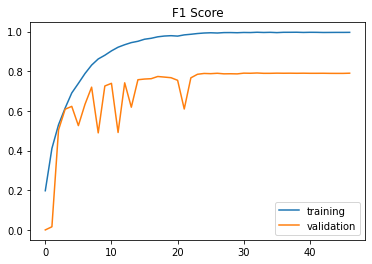

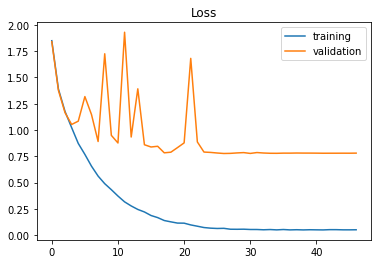

In [ ]:
metric = history.history['f1score']
val_metric = history.history['val_f1score']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(len(metric)), metric, label='training')
plt.plot(range(len(val_metric)), val_metric, label='validation')
plt.legend()
plt.title("F1 Score")

plt.figure()
plt.plot(range(len(loss)), loss, label='training')
plt.plot(range(len(val_loss)), val_loss, label='validation')
plt.legend()
plt.title("Loss")

plt.show()

In [ ]:
y_pred = model.predict(X_test_img)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

In [ ]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.58      0.52      0.55        61
           1       0.64      0.51      0.57       111
           2       0.59      0.54      0.56       198
           3       0.64      0.24      0.35        29
           4       0.87      0.93      0.90      1351
           5       0.76      0.53      0.63        30
           6       0.54      0.50      0.52       223

    accuracy                           0.79      2003
   macro avg       0.66      0.54      0.58      2003
weighted avg       0.78      0.79      0.78      2003



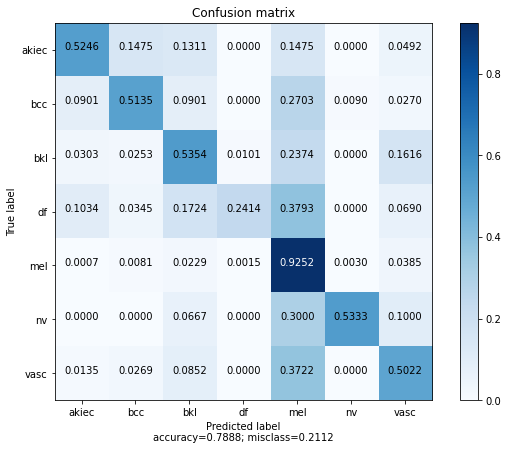

In [ ]:
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
plot_confusion_matrix(confusion_matrix(y_true, y_pred_classes), target_names=classes)

### Save feature extractor

In [ ]:
feature_extractor = models.Model(model.input, model.layers[-2].output)

In [ ]:
feature_extractor.save(os.path.join(PATH, "../VGG16_feature_extractor_8K.h5"))